In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

2025-02-12 13:04:02.289614: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-12 13:04:02.506389: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-12 13:04:03.168774: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-12 13:04:03.168808: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-12 13:04:03.172124: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
# Load test set for generating explanations
test_dataset = tf.data.Dataset.load('test_dataset')
test_dataset = test_dataset.shuffle(64)

2025-02-12 13:04:13.435051: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


(64, 32, 32, 3)
(64, 10)
Normalized values:  (0.0, 1.0)


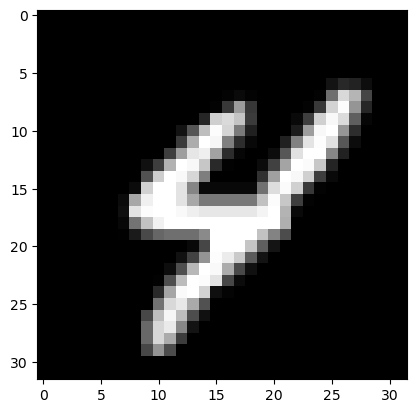

In [4]:
for img_batch, label_batch in test_dataset.take(1):
    print(img_batch.shape)
    print(label_batch.shape)
    img = np.array(img_batch)
    print('Normalized values: ', (np.min(img_batch[0]), np.max(img_batch[0])))
    plt.imshow(img[0])

## 1. Models with different feature extractors

In [10]:
# Load the models
model_extrcs = []
saved_dir    = "models/diff_extrcs"

for model_file in os.listdir(saved_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(saved_dir, model_file)
        model      = tf.keras.models.load_model(model_path)
        model_extrcs.append(model)

In [11]:
for model_file in model_extrcs:
    print(model_file.name)

MobileNetV2_MNIST
CNN_MNIST
Densenet121-MNIST
EfficientNet-MNIST


In [18]:
from tools import LIMEExplainer

lime_explainer = LIMEExplainer()
temp, mask, explanation = lime_explainer.explain_aninstance(image=img[0], model=model_extrcs[0], no_of_samples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

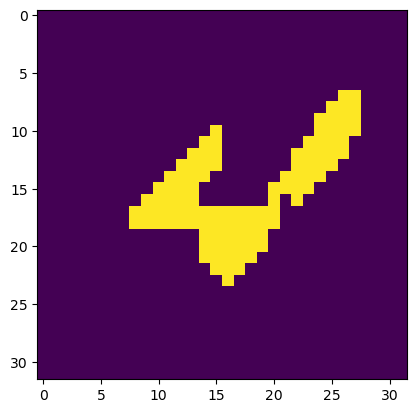

In [19]:
plt.imshow(mask)

In [8]:
import helper_functions

# Seperate images to their respective class as lists
sample_lists = [helper_functions.get_sample(i, test_dataset) for i in range(10)]

In [9]:
# filter out wrong predictions
preds_encods = [helper_functions.get_predictions(model_extrcs, sample_list) for sample_list in sample_lists]
newlists     = [helper_functions.filter_correct_predictions(prediction) for prediction in preds_encods]            # contains correctly predicted images only

Wrong Prediction at index 8 by MobileNetV2_MNIST: Predicted [6], True 0
Wrong Prediction at index 131 by MobileNetV2_MNIST: Predicted [2], True 0
Wrong Prediction at index 26 by MobileNetV2_MNIST: Predicted [8], True 1
Wrong Prediction at index 164 by Densenet121-MNIST: Predicted [6], True 1
Wrong Prediction at index 34 by EfficientNet-MNIST: Predicted [1], True 2
Wrong Prediction at index 54 by MobileNetV2_MNIST: Predicted [8], True 2
Wrong Prediction at index 67 by CNN_MNIST: Predicted [7], True 2
Wrong Prediction at index 139 by EfficientNet-MNIST: Predicted [3], True 2
Wrong Prediction at index 180 by CNN_MNIST: Predicted [7], True 2
Wrong Prediction at index 7 by CNN_MNIST: Predicted [7], True 3
Wrong Prediction at index 9 by Densenet121-MNIST: Predicted [8], True 3
Wrong Prediction at index 90 by MobileNetV2_MNIST: Predicted [5], True 3
Wrong Prediction at index 23 by Densenet121-MNIST: Predicted [9], True 4
Wrong Prediction at index 49 by EfficientNet-MNIST: Predicted [9], True 

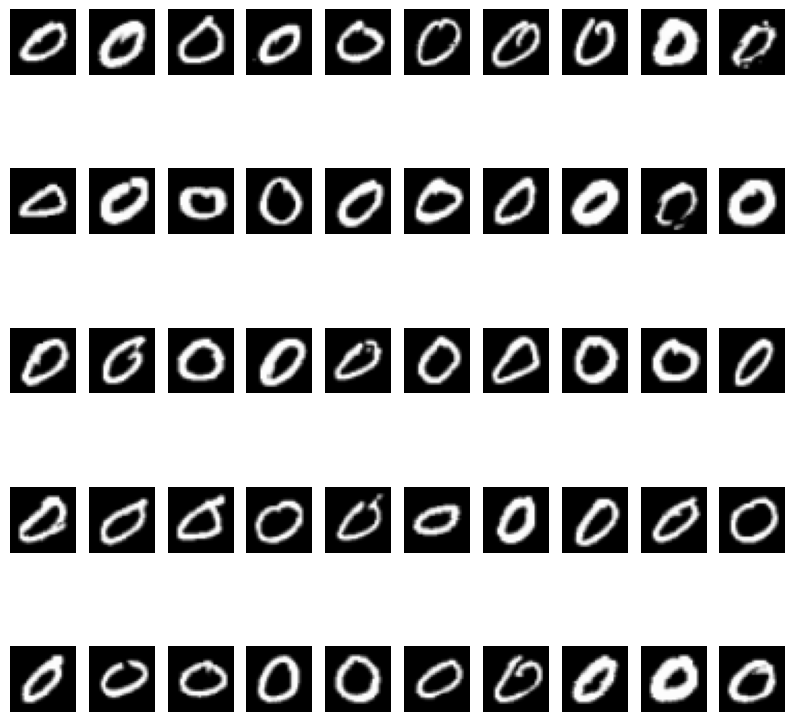

In [9]:
plt.figure(figsize=(10,10))

for index, (image, label) in enumerate(newlists[0][:50]):
    plt.subplot(5,10, index + 1)
    plt.imshow(image.numpy().astype('double'))
    plt.axis('off')

Iteration : 1


  0%|          | 0/300 [00:00<?, ?it/s]

Predicted Class : 0
Explaining Class: 0
Iteration : 2


  0%|          | 0/300 [00:00<?, ?it/s]

Predicted Class : 0
Explaining Class: 0


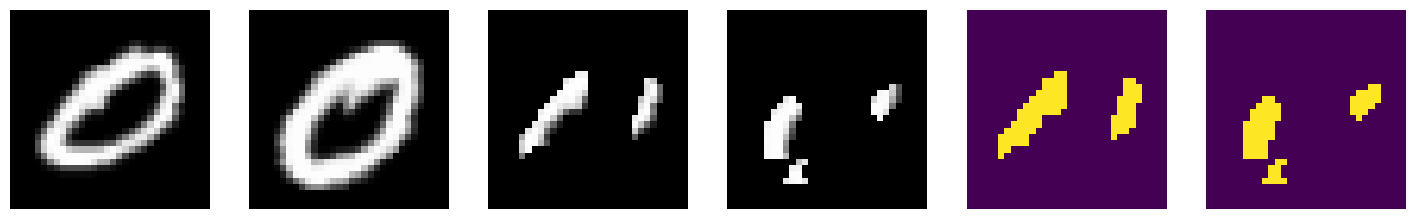

In [11]:
lime_explainer      = LIMEExplainer()
temps, masks, expls = lime_explainer.explanation_fn(newlists[0][:2], model_extrcs[0], 300)

plt.figure(figsize=(18, 6))  
for idx, (img, lbl) in enumerate(newlists[0][:2]):
    plt.subplot(1,6 , idx + 1)
    img = np.array(img)
    plt.imshow(img)
    plt.axis('off')

for i, item in enumerate(temps):
    plt.subplot(1, 6, i + 3)
    plt.imshow(item)
    plt.axis('off')

for i, item in enumerate(masks):
    plt.subplot(1, 6, i + 5)
    plt.imshow(item)
    plt.axis('off')

plt.show()

### Generate explanations for each class

In [ ]:
%%time
save_directory = "LIME_expls/diff_extrcs"

with open(os.devnull, "w") as f:
    with contextlib.redirect_stdout(f):
        lime_explainer.generate_and_save_explanations(newlists, models_encoders, 1000, save_directory)

## 2. Models with different optimizers

In [7]:
# Load models
model_opts = []
saved_dir = "models/diff_opts"

for model_file in os.listdir(saved_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(saved_dir, model_file)
        model      = tf.keras.models.load_model(model_path)
        model_opts.append(model)

In [13]:
for model in model_opts:
    print(model.name)

CNN-MNIST-Adam
CNN_MNIST-SGD
CNN-MNIST-RMSprop
CNN-MNIST-Nadam


In [12]:
# filter out wrong predictions
preds_opts    = [helper_functions.get_predictions(model_opts, sample_list) for sample_list in sample_lists]
newlists_opts = [helper_functions.filter_correct_predictions(prediction) for prediction in preds_opts]

Wrong Prediction at index 49 by CNN-MNIST-RMSprop: Predicted [7], True 0
Wrong Prediction at index 87 by CNN-MNIST-Nadam: Predicted [8], True 0
Wrong Prediction at index 141 by CNN-MNIST-Nadam: Predicted [2], True 0
Wrong Prediction at index 16 by CNN_MNIST-SGD: Predicted [7], True 2
Wrong Prediction at index 33 by CNN-MNIST-Nadam: Predicted [8], True 2
Wrong Prediction at index 117 by CNN-MNIST-RMSprop: Predicted [7], True 2
Wrong Prediction at index 140 by CNN-MNIST-RMSprop: Predicted [8], True 2
Wrong Prediction at index 157 by CNN-MNIST-RMSprop: Predicted [7], True 2
Wrong Prediction at index 27 by CNN_MNIST-SGD: Predicted [5], True 3
Wrong Prediction at index 100 by CNN_MNIST-SGD: Predicted [5], True 3
Wrong Prediction at index 61 by CNN-MNIST-Adam: Predicted [9], True 4
Wrong Prediction at index 91 by CNN_MNIST-SGD: Predicted [9], True 4
Wrong Prediction at index 167 by CNN_MNIST-SGD: Predicted [9], True 4
Wrong Prediction at index 185 by CNN_MNIST-SGD: Predicted [6], True 4
Wron

### Generate explanations

In [ ]:
%%time
import LIME

save_directory = "LIME_expls/diff_optimizers"

with open(os.devnull, "w") as f:
    with contextlib.redirect_stdout(f):
        lime_explainer.generate_and_save_explanations(newlists_opts, models_opts, 1000, save_directory)

## 3. Models with different initial weights 

In [18]:
# load models
model_seeds = []
saved_dir    = "models/diff_seeds"

for model_file in os.listdir(saved_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(saved_dir, model_file)
        model      = tf.keras.models.load_model(model_path)
        model_seeds.append(model)

In [19]:
for i, model in enumerate(model_seeds):
    model._name = f"CNN{i+1}"
    print(model.name)

CNN1
CNN2
CNN3
CNN4
CNN5
CNN6
CNN7
CNN8
CNN9
CNN10


In [20]:
# filter out wrong predictions
preds_seeds    = [helper_functions.get_predictions(model_seeds, sample_list) for sample_list in sample_lists]
newlists_seeds = [helper_functions.filter_correct_predictions(prediction) for prediction in preds_seeds]

Wrong Prediction at index 49 by CNN2: Predicted [6], True 0
Wrong Prediction at index 87 by CNN2: Predicted [6], True 0
Wrong Prediction at index 117 by CNN5: Predicted [6], True 0
Wrong Prediction at index 141 by CNN1: Predicted [2], True 0
Wrong Prediction at index 16 by CNN3: Predicted [7], True 2
Wrong Prediction at index 37 by CNN3: Predicted [7], True 2
Wrong Prediction at index 117 by CNN5: Predicted [7], True 2
Wrong Prediction at index 140 by CNN9: Predicted [8], True 2
Wrong Prediction at index 157 by CNN3: Predicted [7], True 2
Wrong Prediction at index 174 by CNN3: Predicted [7], True 2
Wrong Prediction at index 27 by CNN2: Predicted [5], True 3
Wrong Prediction at index 36 by CNN10: Predicted [7], True 3
Wrong Prediction at index 100 by CNN2: Predicted [5], True 3
Wrong Prediction at index 58 by CNN3: Predicted [1], True 4
Wrong Prediction at index 61 by CNN3: Predicted [9], True 4
Wrong Prediction at index 91 by CNN6: Predicted [9], True 4
Wrong Prediction at index 92 by 

### Generate explanations

In [ ]:
%%time
save_directory = "LIME_expls/diff_seeds"

with open(os.devnull, "w") as f:
    with contextlib.redirect_stdout(f):
        lime_explainer.generate_and_save_explanations(newlists_seeds, models_seeds, 1000, save_directory)